# Copper XRD

In [20]:
import numpy as np
import math
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [2]:
wavelength = 0.1542 #nm
lattice_constant = 0.36 #nm

In [12]:
# Read in the miller indices csv:
planes_df = pd.read_csv('All_Planes_hkl.csv')
miller_indices = planes_df.values
# Store this in a dataframe:
miller_list = [list(row) for row in miller_indices[0:8]]
df = pd.DataFrame({'Miller': miller_list})

In [13]:
df['hkl_squared'] = df['Miller'].apply(lambda x: x[0]**2 + x[1]**2 + x[2]**2)
df['sin theta (rad)'] = df['hkl_squared'].apply(lambda x: math.sqrt((wavelength**2/(4*lattice_constant**2))*x))
df['theta (rad)'] = df['sin theta (rad)'].apply(lambda x:(math.asin(x)))
df['theta (deg)'] = df['theta (rad)'].apply(lambda x: np.rad2deg(x))
df['2 theta (deg)'] = df['theta (deg)'].apply(lambda x: 2 * x)

In [14]:
df

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg)
0,"[1, 0, 0]",1,0.214167,0.215839,12.366642,24.733284
1,"[1, 1, 0]",2,0.302877,0.307710,17.630509,35.261018
2,"[1, 1, 1]",3,0.370948,0.380029,21.774067,43.548134
3,"[2, 0, 0]",4,0.428333,0.442648,25.361836,50.723671
4,"[2, 1, 0]",5,0.478891,0.499391,28.613011,57.226022
5,"[2, 1, 1]",6,0.524599,0.552244,31.641256,63.282511
6,"[2, 2, 0]",8,0.605755,0.650714,37.283177,74.566354
7,"[2, 2, 1]",9,0.642500,0.697756,39.978492,79.956984


In [15]:
# Define atom positons in cubic cell:
Cu_positions = np.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.0], [0.5, 0.0, 0.5], [0.0, 0.5, 0.5]])

In [16]:
# This calculates the term that will be multiplied by the atomic scattering factor
# for each atom type and for each miller incices
def compute_structure_factor_term(atom_positions, miller_indices_array):
    results = {}
    
    for miller_indices in miller_indices_array:
        h, k, l = miller_indices
        total = 0
        
        for position in atom_positions:
            position_adjusted = 2*position # distribute the 2 in the exponential factor to each atom position
            x, y, z = position_adjusted
            value = x * h + y * k + z * l

            # Check if value is even or 0
            if value % 2 == 0:
                total += 1
            # If value is odd
            else:
                total -= 1
        
        # Store the result with Miller indices as the key
        results[tuple(miller_indices)] = total
    
    return results

In [17]:
Cu_structure_factor_term = compute_structure_factor_term(Cu_positions, miller_indices)
print("Cu", Cu_structure_factor_term)

Cu {(1, 0, 0): 0, (1, 1, 0): 0, (1, 1, 1): 4, (2, 0, 0): 4, (2, 1, 0): 0, (2, 1, 1): 0, (2, 2, 0): 4, (2, 2, 1): 0, (3, 0, 0): 0, (3, 1, 0): 0, (3, 1, 1): 4, (2, 2, 2): 4, (3, 2, 0): 0, (3, 2, 1): 0, (4, 0, 0): 4, (3, 2, 2): 0, (4, 1, 0): 0, (3, 3, 0): 0, (4, 1, 1): 0, (3, 3, 1): 4, (4, 2, 0): 4, (4, 2, 1): 0, (3, 3, 2): 0, (4, 2, 2): 4, (5, 0, 0): 0, (4, 3, 1): 0, (5, 1, 0): 0, (3, 3, 3): 4, (5, 1, 1): 4, (4, 3, 2): 0, (5, 2, 0): 0, (5, 2, 1): 0, (4, 4, 0): 4, (4, 4, 1): 0, (5, 2, 2): 0, (4, 3, 3): 0, (5, 3, 0): 0, (5, 3, 1): 4, (4, 4, 2): 4, (6, 0, 0): 4, (6, 1, 0): 0, (5, 2, 3): 0, (6, 2, 0): 4, (4, 4, 3): 0, (5, 4, 0): 0, (5, 4, 1): 0, (5, 2, 4): 0, (4, 4, 4): 4}


In [18]:
# This calculates f, the atomic scattering factor, for each atom time at each theta angle 
# check the angle calculation units
def calc_atomic_scattering_factor(theta, atomic_number, a1, b1, a2, b2, a3, b3, a4=None, b4=None, wavelength = 0.1542):
    s = math.sin(theta)/(wavelength*10)
    f = atomic_number - (41.78214 * s**2) * (a1*np.e**(-b1*s**2) + a2*np.e**(-b2*s**2) + a3*np.e**(-b3*s**2) + a4*np.e**(-b4*s**2))
    return f

In [21]:
# Define function to calculate multiplicity facor for each plane:
def get_unique_permutations(hkl):
    # Get all permutations of the Miller indices
    perms = list(itertools.permutations(hkl))
    
    # For each permutation, consider all possible sign changes
    all_permutations = []
    for perm in perms:
        signs = itertools.product([1, -1], repeat=3)
        for sign in signs:
            all_permutations.append(tuple([i*j for i, j in zip(perm, sign)]))
    
    # Return unique permutations (planes)
    return set(all_permutations)

In [22]:
# Calculate the structure factors using the atomic scattering factors- 
# i need to go through this math to make sure it is correct- 
# it definitely doesnt match the peak intensities given on mateirals project
df['Cu_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 29, 1.579, 62.940, 1.820, 12.453, 1.658, 2.504, 0.532, 0.333))
df['Structure Factor'] = df['Cu_f'] * df['Miller'].apply(lambda x: Cu_structure_factor_term[tuple(x)])
df['F^2'] = df['Structure Factor']**2
#df['p'] = [8, 6, 12]
df['p'] = df['Miller'].apply(lambda x: len(get_unique_permutations(x)))
df['Lorentz_factor'] = df['theta (rad)'].apply(lambda x: (1+(math.cos(2*x)**2)) / (math.sin(x)**2 * math.cos(x)))
df['Intensity'] = df['F^2']*df['p']*df['Lorentz_factor']
df["Intensity_norm"] = (df["Intensity"]/df["Intensity"].max())*100


In [23]:
df

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg),Cu_f,Structure Factor,F^2,p,Lorentz_factor,Intensity,Intensity_norm
0,"[1, 0, 0]",1,0.214167,0.215839,12.366642,24.733284,25.769076,0.000000,0.000000,6,40.732573,0.000000,0.000000
1,"[1, 1, 0]",2,0.302877,0.307710,17.630509,35.261018,23.687806,0.000000,0.000000,12,19.064398,0.000000,0.000000
2,"[1, 1, 1]",3,0.370948,0.380029,21.774067,43.548134,22.029430,88.117720,7764.732585,8,11.936711,741482.932708,100.000000
3,"[2, 0, 0]",4,0.428333,0.442648,25.361836,50.723671,20.637955,82.551818,6814.802720,6,8.449203,345477.906020,46.592833
4,"[2, 1, 0]",5,0.478891,0.499391,28.613011,57.226022,19.454502,0.000000,0.000000,24,6.422498,0.000000,0.000000
5,"[2, 1, 1]",6,0.524599,0.552244,31.641256,63.282511,18.436180,0.000000,0.000000,24,5.130853,0.000000,0.000000
6,"[2, 2, 0]",8,0.605755,0.650714,37.283177,74.566354,16.759449,67.037795,4494.065912,12,3.667755,197797.600592,26.675948
7,"[2, 2, 1]",9,0.642500,0.697756,39.978492,79.956984,16.051280,0.000000,0.000000,24,3.257418,0.000000,0.000000


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

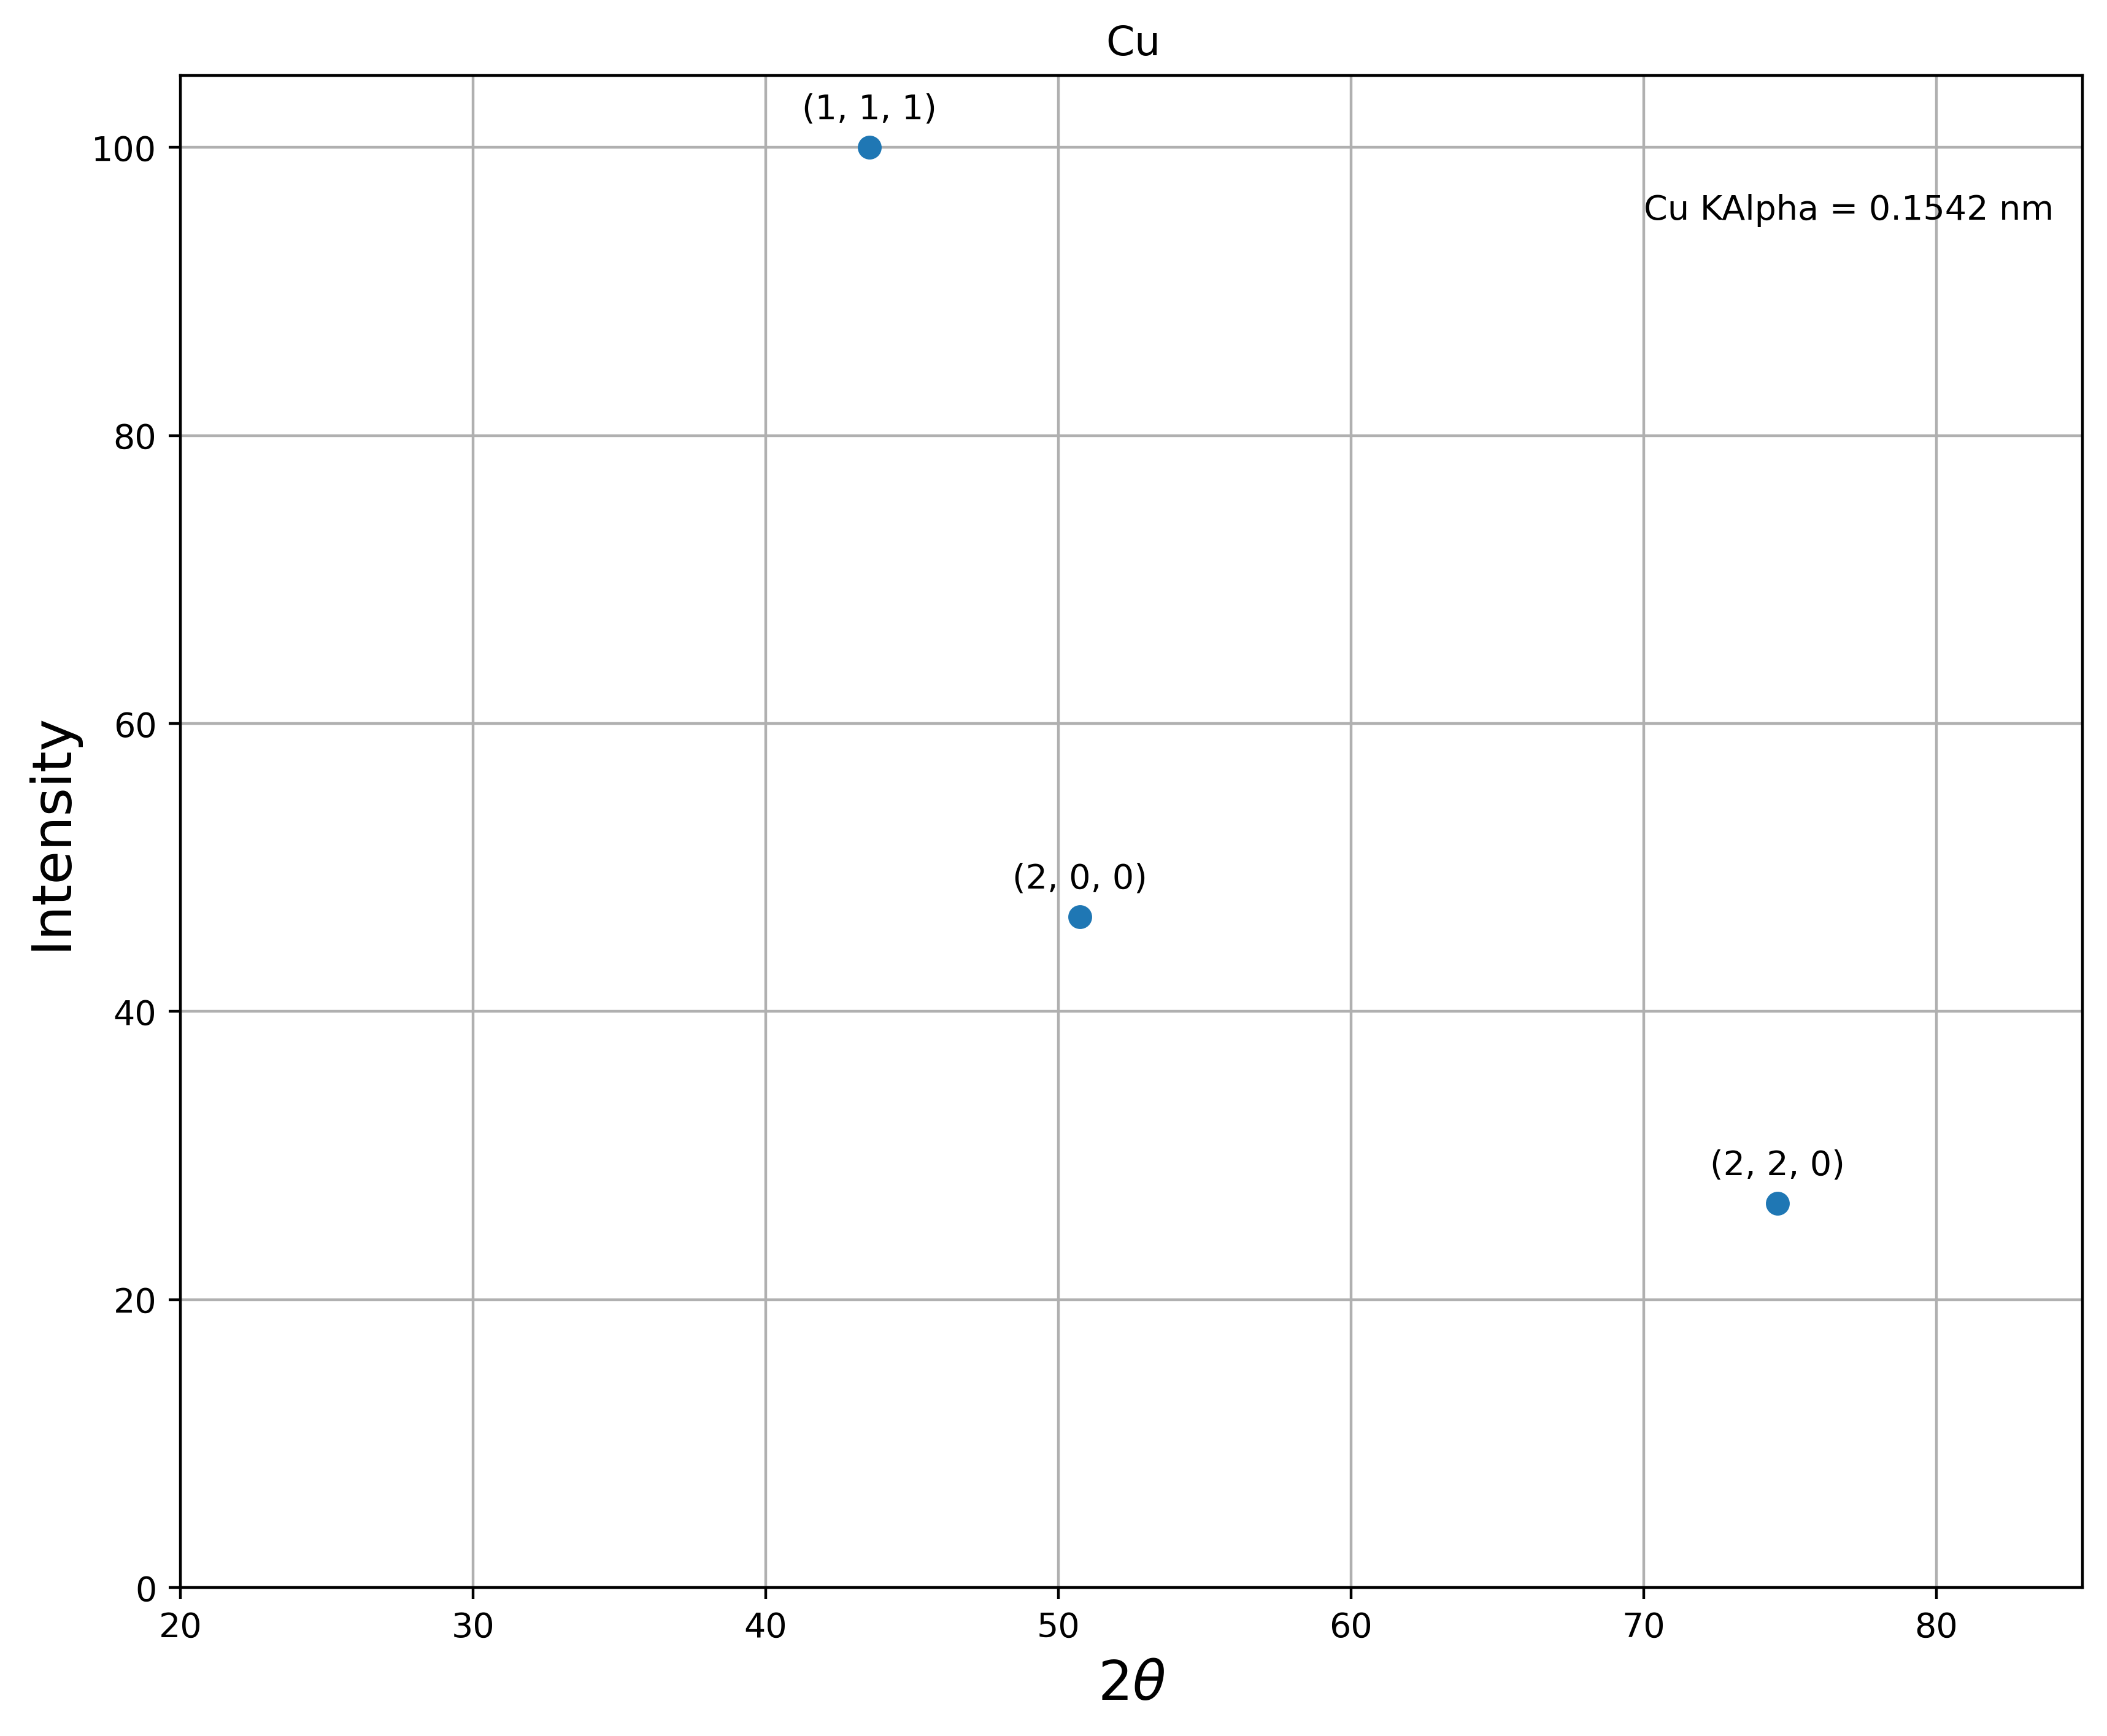

In [27]:
fig = plt.figure(figsize=(10, 8), dpi = 400)
filtered_df = df[df['Intensity_norm'] != 0]
x = filtered_df['2 theta (deg)']
y = filtered_df['Intensity_norm']
plt.plot(x, y, 'o')

# Add text labels above each data point
for index, row in filtered_df.iterrows():
    label = str(row['Miller']).replace('[', '(').replace(']', ')')
    x = row['2 theta (deg)']
    y = row['Intensity_norm']
    plt.text(x, y + 0.02 * max(filtered_df['Intensity_norm']), label, ha='center')

# Figure formatting
plt.text(70, 95, "Cu KAlpha = 0.1542 nm")
plt.xlim(20, 85)
plt.ylim(0, 105)
plt.xlabel("2"r'$\theta$', fontsize = 16)
plt.ylabel('Intensity', fontsize = 16)
plt.title(r'$\mathrm{Cu}$')
plt.grid()
plt.tight_layout